In [2]:
# Importing necessary libraries
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Loading the data
df = pd.read_excel("Superstore.xls")
furniture = df.loc[df['Category'] == 'Furniture']

In [3]:
# General Overview of Data
print(furniture.info())
print(furniture.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2121 entries, 0 to 9990
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         2121 non-null   int64         
 1   Order ID       2121 non-null   object        
 2   Order Date     2121 non-null   datetime64[ns]
 3   Ship Date      2121 non-null   datetime64[ns]
 4   Ship Mode      2121 non-null   object        
 5   Customer ID    2121 non-null   object        
 6   Customer Name  2121 non-null   object        
 7   Segment        2121 non-null   object        
 8   Country        2121 non-null   object        
 9   City           2121 non-null   object        
 10  State          2121 non-null   object        
 11  Postal Code    2121 non-null   int64         
 12  Region         2121 non-null   object        
 13  Product ID     2121 non-null   object        
 14  Category       2121 non-null   object        
 15  Sub-Category   2121 n

In [4]:
# Check for missing values
print(furniture.isnull().sum())

Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64


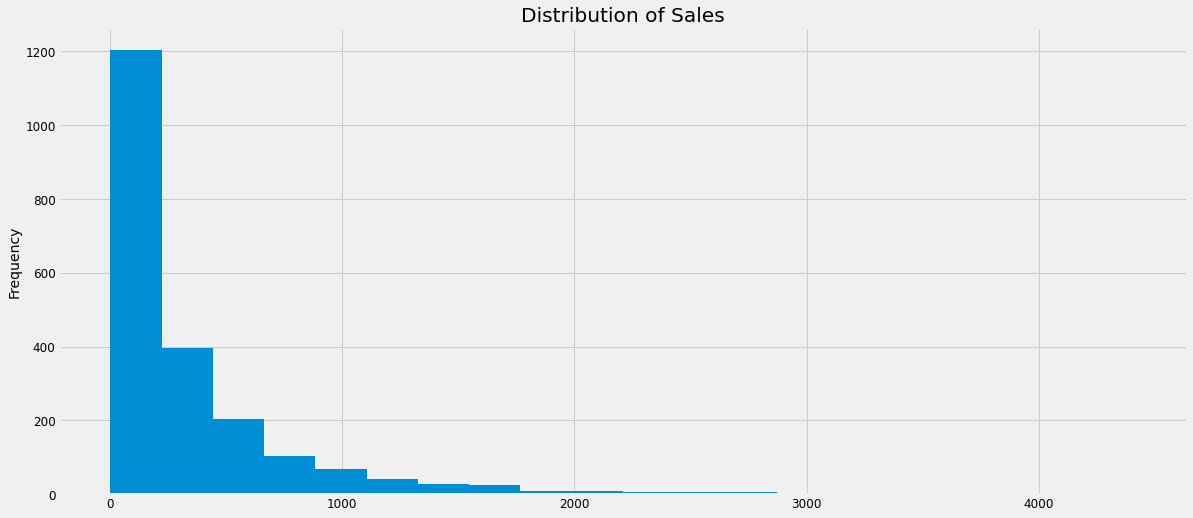

In [5]:
# Sales Distribution
furniture['Sales'].plot(kind='hist', bins=20, title='Distribution of Sales')
plt.show()

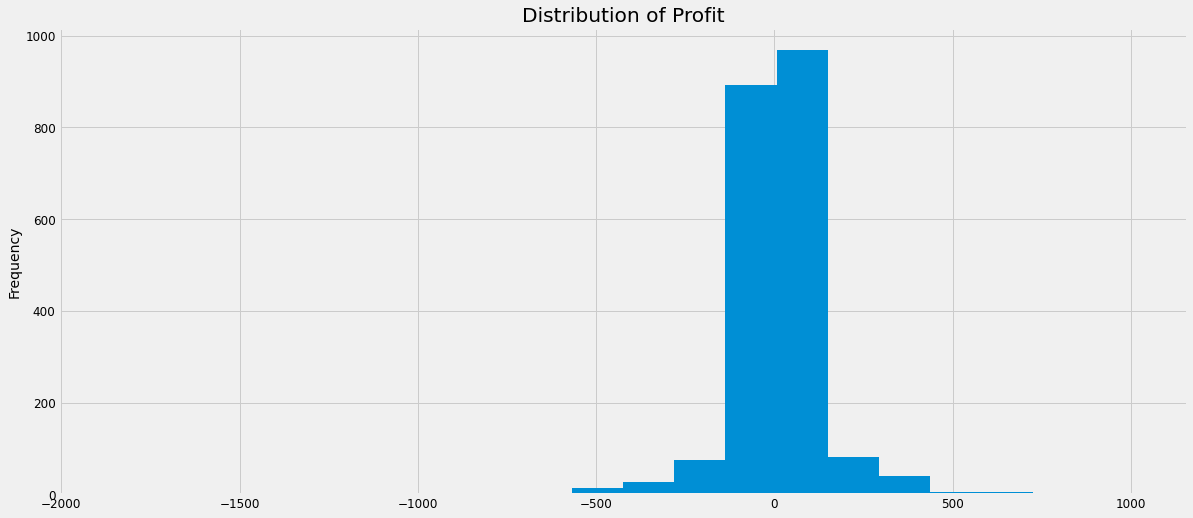

In [6]:
# Profit Distribution
furniture['Profit'].plot(kind='hist', bins=20, title='Distribution of Profit')
plt.show()

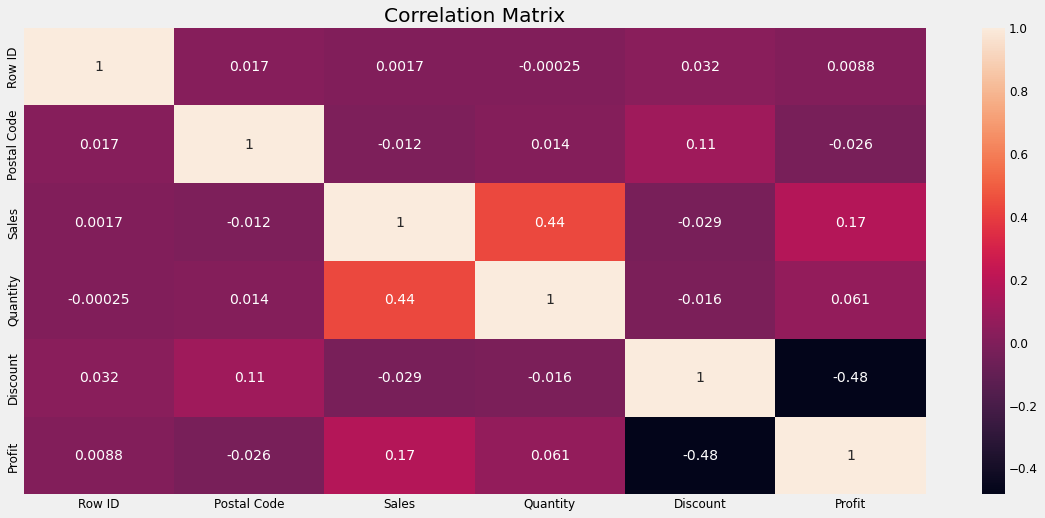

In [9]:
# Correlation Matrix
import seaborn as sns

correlation_matrix = furniture.corr()
sns.heatmap(correlation_matrix, annot=True)
plt.title('Correlation Matrix')
plt.show()

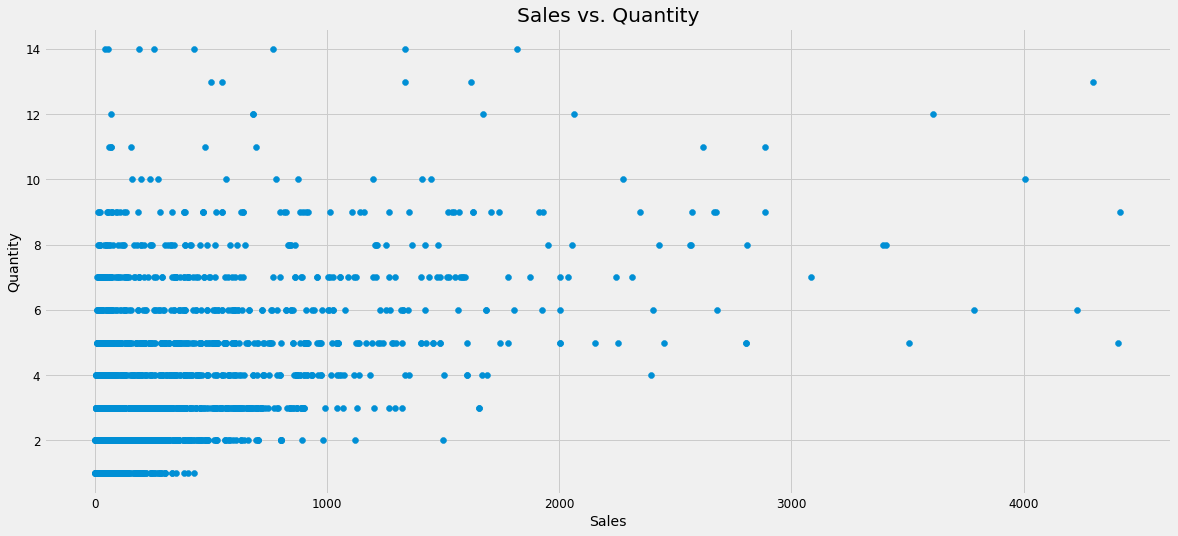

In [10]:
# Scatter Plot for Sales vs. Quantity
plt.scatter(furniture['Sales'], furniture['Quantity'])
plt.title('Sales vs. Quantity')
plt.xlabel('Sales')
plt.ylabel('Quantity')
plt.show()

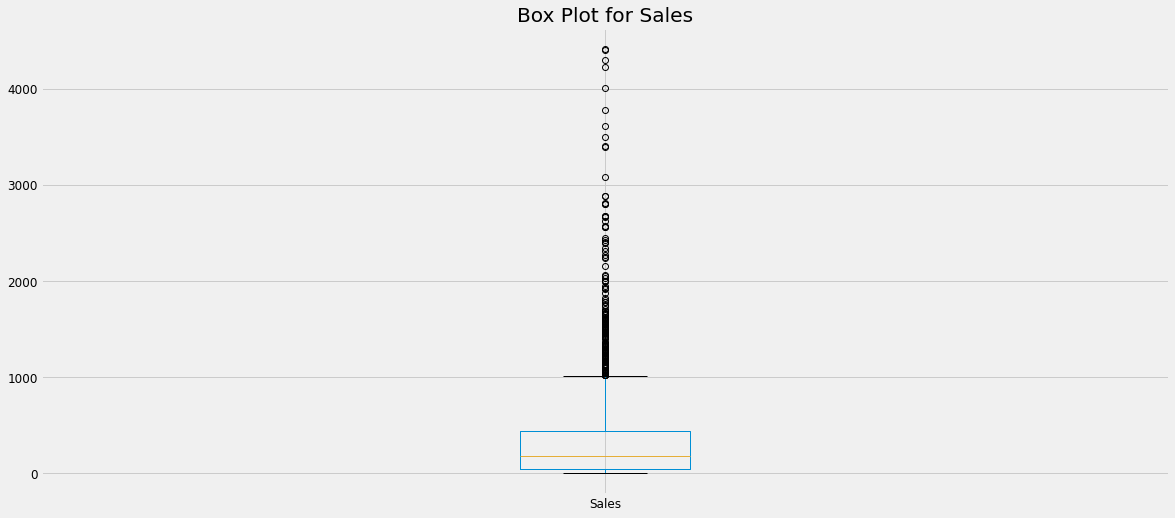

In [12]:
# Box Plot to detect outliers in Sales
furniture.boxplot(column=['Sales'])
plt.title('Box Plot for Sales')
plt.show()

In [13]:
# Selecting relevant columns and setting 'Order Date' as the index
furniture = furniture[['Order Date', 'Sales', 'Quantity', 'Discount', 'Profit']]
furniture.set_index('Order Date', inplace=True)

# Resampling the data by month and filling missing values with zero
furniture_monthly = furniture.resample('M').sum().fillna(0)

# Normalizing the data using MinMaxScaler
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(furniture_monthly)

In [14]:
# Creating sequences of 3 months data to predict the 4th month
X, y = [], []
for i in range(len(data_normalized)-3):
    X.append(data_normalized[i:i+3])
    y.append(data_normalized[i+3, 0]) # 'Sales' is the first column

X, y = np.array(X), np.array(y)

In [15]:
# Building the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X.shape[1], X.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Training the model
model.fit(X, y, epochs=50, batch_size=12)

Epoch 1/50
4/4 [==============================] - 3s 15ms/step - loss: 0.2716
Epoch 2/50
4/4 [==============================] - 0s 15ms/step - loss: 0.2329
Epoch 3/50
4/4 [==============================] - 0s 15ms/step - loss: 0.1993
Epoch 4/50
4/4 [==============================] - 0s 17ms/step - loss: 0.1679
Epoch 5/50
4/4 [==============================] - 0s 14ms/step - loss: 0.1390
Epoch 6/50
4/4 [==============================] - 0s 13ms/step - loss: 0.1094
Epoch 7/50
4/4 [==============================] - 0s 13ms/step - loss: 0.0880
Epoch 8/50
4/4 [==============================] - 0s 14ms/step - loss: 0.0713
Epoch 9/50
4/4 [==============================] - 0s 14ms/step - loss: 0.0641
Epoch 10/50
4/4 [==============================] - 0s 14ms/step - loss: 0.0582
Epoch 11/50
4/4 [==============================] - 0s 13ms/step - loss: 0.0619
Epoch 12/50
4/4 [==============================] - 0s 13ms/step - loss: 0.0634
Epoch 13/50
4/4 [==============================] - 0s 13ms/st

2/2 [==============================] - 0s 4ms/step


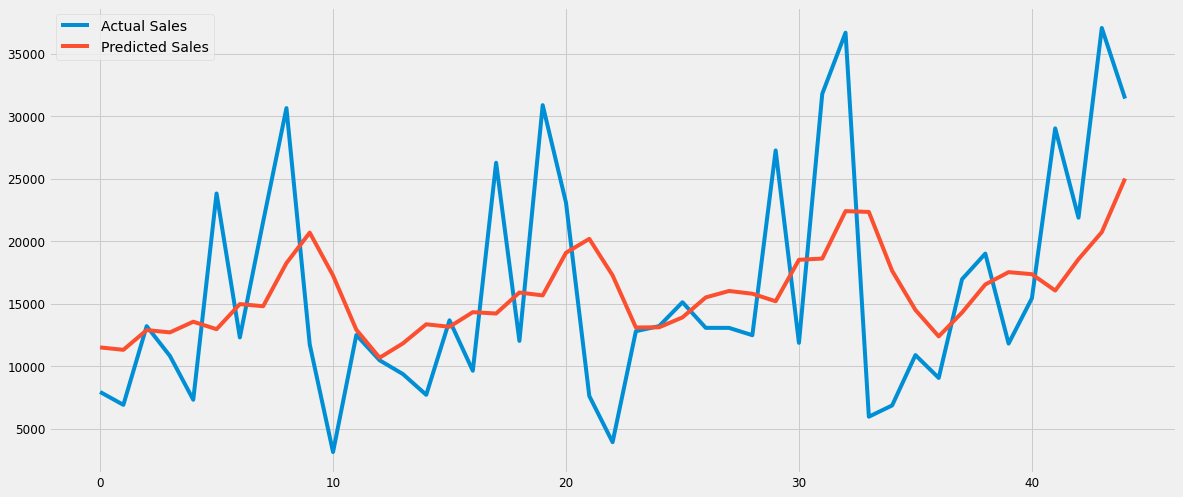

In [16]:
# Making predictions
y_pred = model.predict(X)

# Transforming the predictions back to original scale
y_pred_original = scaler.inverse_transform(np.hstack((y_pred, np.zeros((y_pred.shape[0], data_normalized.shape[1]-1)))))
y_true_original = scaler.inverse_transform(np.hstack((y.reshape(-1,1), np.zeros((y_pred.shape[0], data_normalized.shape[1]-1)))))

# Plotting actual vs predicted sales
plt.plot(y_true_original[:, 0], label='Actual Sales')
plt.plot(y_pred_original[:, 0], label='Predicted Sales')
plt.legend()
plt.show()